In [12]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

In [13]:
#import participant DED data
df = pd.read_excel("Test LOOK Participant.xlsx")
df = df.dropna(subset=['Nom'])
info_df = pd.read_excel("Test LOOK Participant.xlsx")
info_df['participant_code'] = info_df['numéro'].apply(lambda x: f"{int(x):02d}_EB")
de_dict = dict(zip(info_df['participant_code'], info_df['DE?']))

participants = df[['Nom', 'OSDI-6', 'DE?']].copy()

total_participants = len(participants)

de_counts = participants['DE?'].value_counts()

print("Participant Table:")
print(participants)
print("\nSummary:")
print(f"Total participants: {total_participants}")
print(f"Number with DE (OUI): {de_counts.get('OUI', 0)}")
print(f"Number without DE (NON): {de_counts.get('NON', 0)}")

Participant Table:
                        Nom  OSDI-6  DE?
0             GENDRE Jérémy       2  NON
1   BROSSIER-DELAINE Alwena       4  OUI
2             MABROUK Yahya       6  OUI
3              AUGER Jeanne       1  NON
4           ROMANACCE Lucas       2  NON
5             MAGNANT Oscar       1  NON
6               SKORO Louka       2  NON
7            MINEAU Tristan       6  OUI
8             GUILLOU Lucas       5  OUI
9            MAFFLI Vincent       3  NON
10         Aleksandr Volkov      15  OUI
11         EL MGHAZLI Idris       7  OUI
12             BRUN Emilien       6  OUI

Summary:
Total participants: 13
Number with DE (OUI): 7
Number without DE (NON): 6


In [14]:
participant = "05_EB"

In [15]:
order = ["tapis_1", "tapis_2", "conversation_1", "conversation_2", "work"]

# Read the Excel file
df = pd.read_excel("blink_MBI_analysis_summary.xlsx")

df_part = df[df['Task_ID'].str.startswith(participant)]
df_part['task_type'] = df_part['Task_ID'].str.extract(r'_(tapis_1|tapis_2|conversation_1|conversation_2|work)$')
df_part = df_part[df_part['task_type'].isin(order)]
df_part['order'] = df_part['task_type'].map({k: v for v, k in enumerate(order)})
df_part = df_part.sort_values('order')
df_part['MBI_value'] = df_part['MBI Value (Longest Gap, s)'].astype(str).str.replace(',', '.').astype(float)

# Apply condition: if value < 1s, set to 60s
df_part.loc[df_part['MBI_value'] < 1, 'MBI_value'] = 60



C:\Users\yuz\AppData\Local\Temp\ipykernel_10656\2048647280.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part['task_type'] = df_part['Task_ID'].str.extract(r'_(tapis_1|tapis_2|conversation_1|conversation_2|work)$')


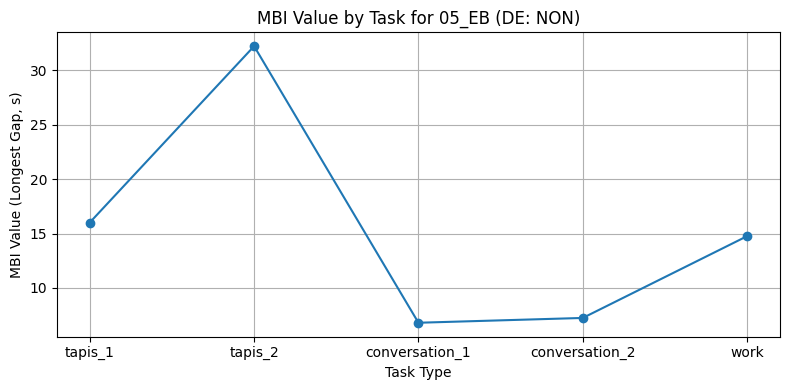

In [16]:
# Plot for one participant
de_status = de_dict.get(participant, "Unknown")

plt.figure(figsize=(8, 4))
plt.plot(df_part['task_type'], df_part['MBI_value'], marker='o')
plt.ylabel('MBI Value (Longest Gap, s)')
plt.xlabel('Task Type')
plt.title(f"MBI Value by Task for {participant} (DE: {de_status})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
participant_prefix = "EB"
num_range = (1, 10)

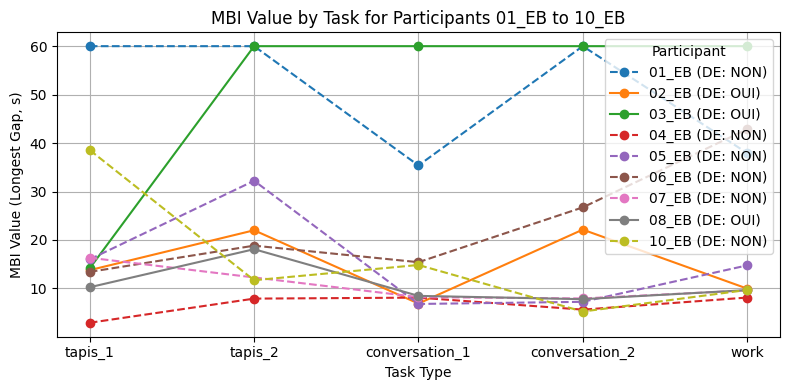

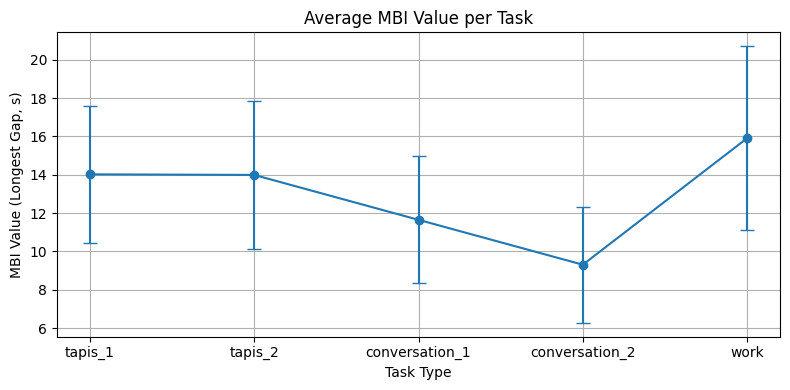

In [18]:
plt.figure(figsize=(8, 4))

for i in range(num_range[0], num_range[1] + 1):
    participant = f"{i:02d}_{participant_prefix}"
    df_part = df[df['Task_ID'].str.startswith(participant)].copy()
    df_part['task_type'] = df_part['Task_ID'].str.extract(r'_(tapis_1|tapis_2|conversation_1|conversation_2|work)$')
    df_part = df_part[df_part['task_type'].isin(order)]
    df_part['order'] = df_part['task_type'].map({k: v for v, k in enumerate(order)})
    df_part = df_part.sort_values('order')

    # Parse MBI values, replace commas, convert to float
    df_part['MBI_value'] = df_part['MBI Value (Longest Gap, s)'].astype(str).str.replace(',', '.').astype(float)
    df_part.loc[df_part['MBI_value'] < 1, 'MBI_value'] = 60

    # Get DE status for this participant
    de_status = de_dict.get(participant, "Unknown")
    linestyle = '-' if de_status == "OUI" else '--'

    if not df_part.empty:
        plt.plot(
            df_part['task_type'],
            df_part['MBI_value'],
            marker='o',
            label=f"{participant} (DE: {de_status})",
            linestyle=linestyle
        )

plt.ylabel('MBI Value (Longest Gap, s)')
plt.xlabel('Task Type')
plt.title(f'MBI Value by Task for Participants {num_range[0]:02d}_EB to {num_range[1]:02d}_EB')
plt.grid(True)
plt.legend(title='Participant', loc='upper right')  # <-- Top-right legend
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

def plot_group_average_mbi(df, order=None, show_errorbars=True, errorbar_type='sem'):
    """
    Plots the average MBI value per task, with optional error bars.
    :param df: DataFrame containing columns ['task_type', 'MBI_value']
    :param order: List specifying task_type order for x-axis
    :param show_errorbars: If True, show error bars (SEM or std)
    :param errorbar_type: 'sem' for standard error of mean, 'std' for standard deviation
    """
    # Group by task_type, aggregate
    group = df.groupby('task_type')['MBI_value']
    mean_mbi = group.mean()
    if errorbar_type == 'sem':
        err = group.sem()
    else:
        err = group.std()

    # Order if specified
    if order is not None:
        mean_mbi = mean_mbi.reindex(order)
        err = err.reindex(order)
    x = mean_mbi.index

    plt.figure(figsize=(8, 4))
    plt.errorbar(x, mean_mbi, yerr=err if show_errorbars else None, fmt='o-', capsize=5, label='Group average')
    plt.ylabel('MBI Value (Longest Gap, s)')
    plt.xlabel('Task Type')
    plt.title('Average MBI Value per Task')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 1. Load the data
mbi_file = r"C:/Users/yuz/Documents/Test_LOOK/blink_MBI_analysis_summary.xlsx"
df_mbi = pd.read_excel(mbi_file)

# 2. Extract task type
df_mbi['task_type'] = df_mbi['Task_ID'].str.extract(r'_(tapis_1|tapis_2|conversation_1|conversation_2|work)$')[0]

# 3. Parse MBI values
df_mbi['MBI_value'] = df_mbi['MBI Value (Longest Gap, s)'].astype(str).str.replace(',', '.').astype(float)

# 4. Plot
order = ['tapis_1', 'tapis_2', 'conversation_1', 'conversation_2', 'work']
plot_group_average_mbi(df_mbi, order=order)



In [19]:
excluded_participant = ["03_EB", "04_EB"]

In [20]:
#linear regression for MBI vs OSDI-6
df['MBI_value'] = df['MBI Value (Longest Gap, s)'].astype(str).str.replace(',', '.').astype(float)
df.loc[df['MBI_value'] < 1, 'MBI_value'] = 60
df['Participant'] = df['Task_ID'].str.extract(r'(\d{2}_EB)')

df_avg_mbi = df.groupby('Participant')['MBI_value'].mean().reset_index()
df_avg_mbi.columns = ['Participant', 'Avg_MBI']

# ---- exclude participants by the extreme value ("03_EB" et "04_EB") ----
df_avg_mbi = df_avg_mbi[~df_avg_mbi['Participant'].isin(excluded_participant)]

info_df['Participant'] = info_df['participant_code']
df_osdi = info_df[['Participant', 'OSDI-6']]

df_merged = pd.merge(df_avg_mbi, df_osdi, on='Participant', how='left')
x = df_merged['OSDI-6']
y = df_merged['Avg_MBI']

mask = x.notna() & y.notna()
x = x[mask]
y = y[mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)


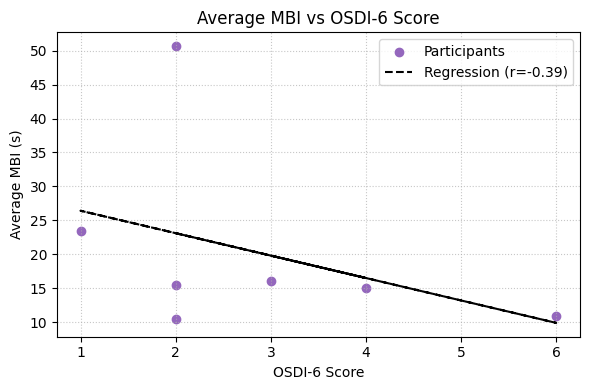

In [21]:
#plot the result of regression
plt.figure(figsize=(6, 4))
plt.scatter(x, y, color='tab:purple', label='Participants')
plt.plot(x, slope * x + intercept, color='black', linestyle='--', label=f'Regression (r={r_value:.2f})')
plt.xlabel('OSDI-6 Score')
plt.ylabel('Average MBI (s)')
plt.title('Average MBI vs OSDI-6 Score')
plt.grid(True, linestyle='dotted', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
excluded_participant = ["03_EB", "04_EB"]

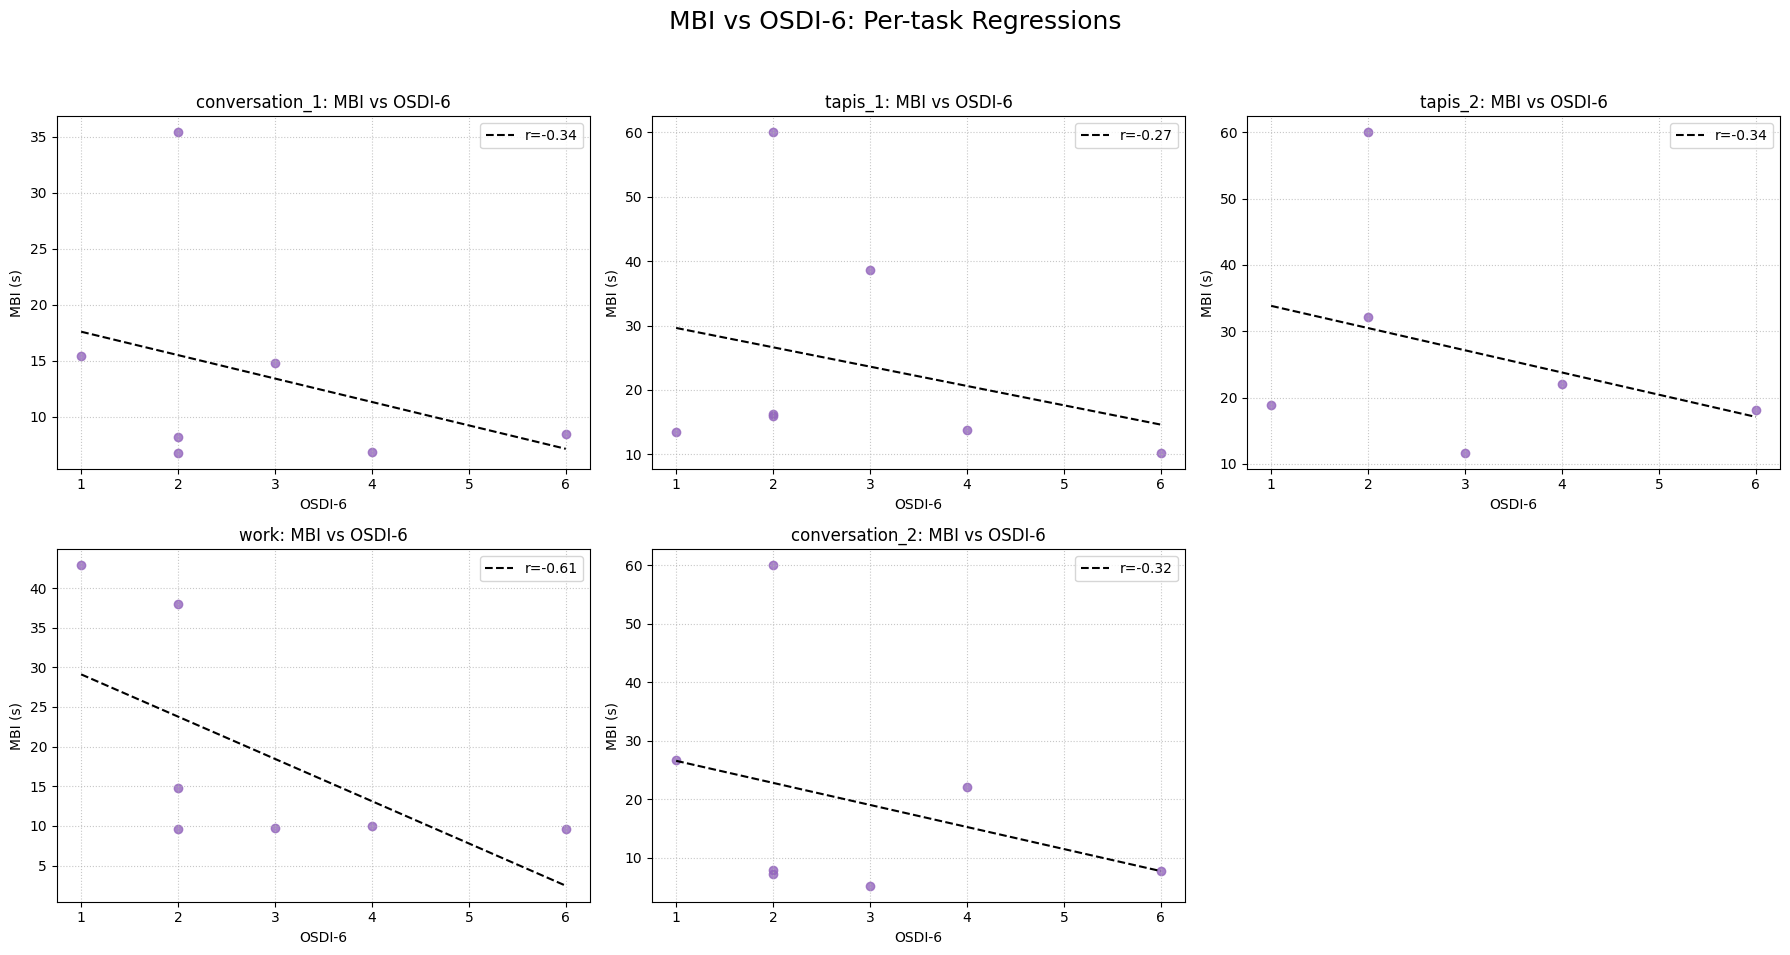

In [23]:
#plot by task
# Ensure 'task_type' and 'Participant' exist
if 'task_type' not in df.columns and 'Task_ID' in df.columns:
    df['task_type'] = df['Task_ID'].str.extract(r'_(tapis_1|tapis_2|conversation_1|conversation_2|work)$')
if 'Participant' not in df.columns and 'Task_ID' in df.columns:
    df['Participant'] = df['Task_ID'].str.extract(r'(\d{2}_EB)')

# Exclude participant(s)
df = df[~df['Participant'].isin(excluded_participant)]

task_list = [t for t in df['task_type'].dropna().unique() if isinstance(t, str)]
n_tasks = len(task_list)

# Choose subplot grid (2 columns)
n_cols = 3
n_rows = math.ceil(n_tasks / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, task in enumerate(task_list):
    ax = axes[i]
    df_task = df[df['task_type'] == task].copy()
    df_task['MBI_value'] = df_task['MBI Value (Longest Gap, s)'].astype(str).str.replace(',', '.').astype(float)
    df_task.loc[df_task['MBI_value'] < 1, 'MBI_value'] = 60

    # Merge with OSDI
    df_task_merged = pd.merge(df_task[['Participant', 'MBI_value']], df_osdi, on='Participant', how='left')
    x = df_task_merged['OSDI-6']
    y = df_task_merged['MBI_value']
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]
    if len(x) > 2:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        ax.scatter(x, y, color='tab:purple', alpha=0.8)
        ax.plot(np.sort(x), slope * np.sort(x) + intercept, color='black', linestyle='--', label=f'r={r_value:.2f}')
        ax.set_title(f'{task}: MBI vs OSDI-6')
        ax.set_xlabel('OSDI-6')
        ax.set_ylabel('MBI (s)')
        ax.legend()
    else:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_title(f'{task}: MBI vs OSDI-6')
        ax.set_xlabel('OSDI-6')
        ax.set_ylabel('MBI (s)')
    ax.grid(True, linestyle='dotted', alpha=0.7)

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('MBI vs OSDI-6: Per-task Regressions', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [24]:
#DEQ-5 data load

info_df = pd.read_excel("Test LOOK Participant.xlsx")
if 'Participant' not in info_df.columns and 'numéro' in info_df.columns:
    info_df['Participant'] = info_df['numéro'].apply(lambda n: f"{int(n):02d}_EB")
if 'DEQ-5' not in info_df.columns and 'DEQ_5' in info_df.columns:
    info_df['DEQ-5'] = info_df['DEQ_5']

In [25]:
excluded_participant = ["03_EB", "04_EB"]

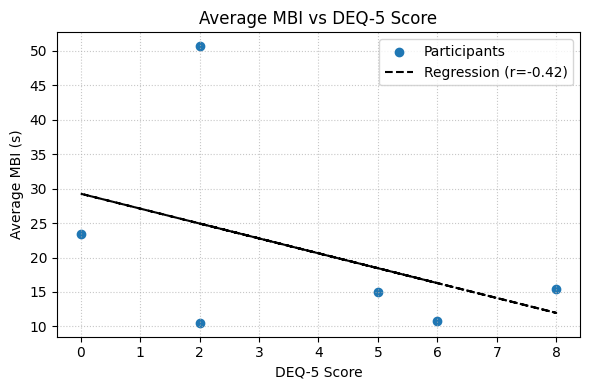

In [26]:
#plot MBI vs DEQ-5


df_avg_mbi = df_avg_mbi[~df_avg_mbi['Participant'].isin(excluded_participant)]
df_merged = pd.merge(df_avg_mbi, info_df[['Participant', 'DEQ-5']], on='Participant', how='left')

x = df_merged['DEQ-5']
y = df_merged['Avg_MBI']
mask = x.notna() & y.notna()
x = x[mask]
y = y[mask]

if len(x) > 2:
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, color='tab:blue', label='Participants')
    plt.plot(x, slope * x + intercept, color='black', linestyle='--', label=f'Regression (r={r_value:.2f})')
    plt.xlabel('DEQ-5 Score')
    plt.ylabel('Average MBI (s)')
    plt.title('Average MBI vs DEQ-5 Score')
    plt.grid(True, linestyle='dotted', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for regression plot (Average MBI vs DEQ-5).")


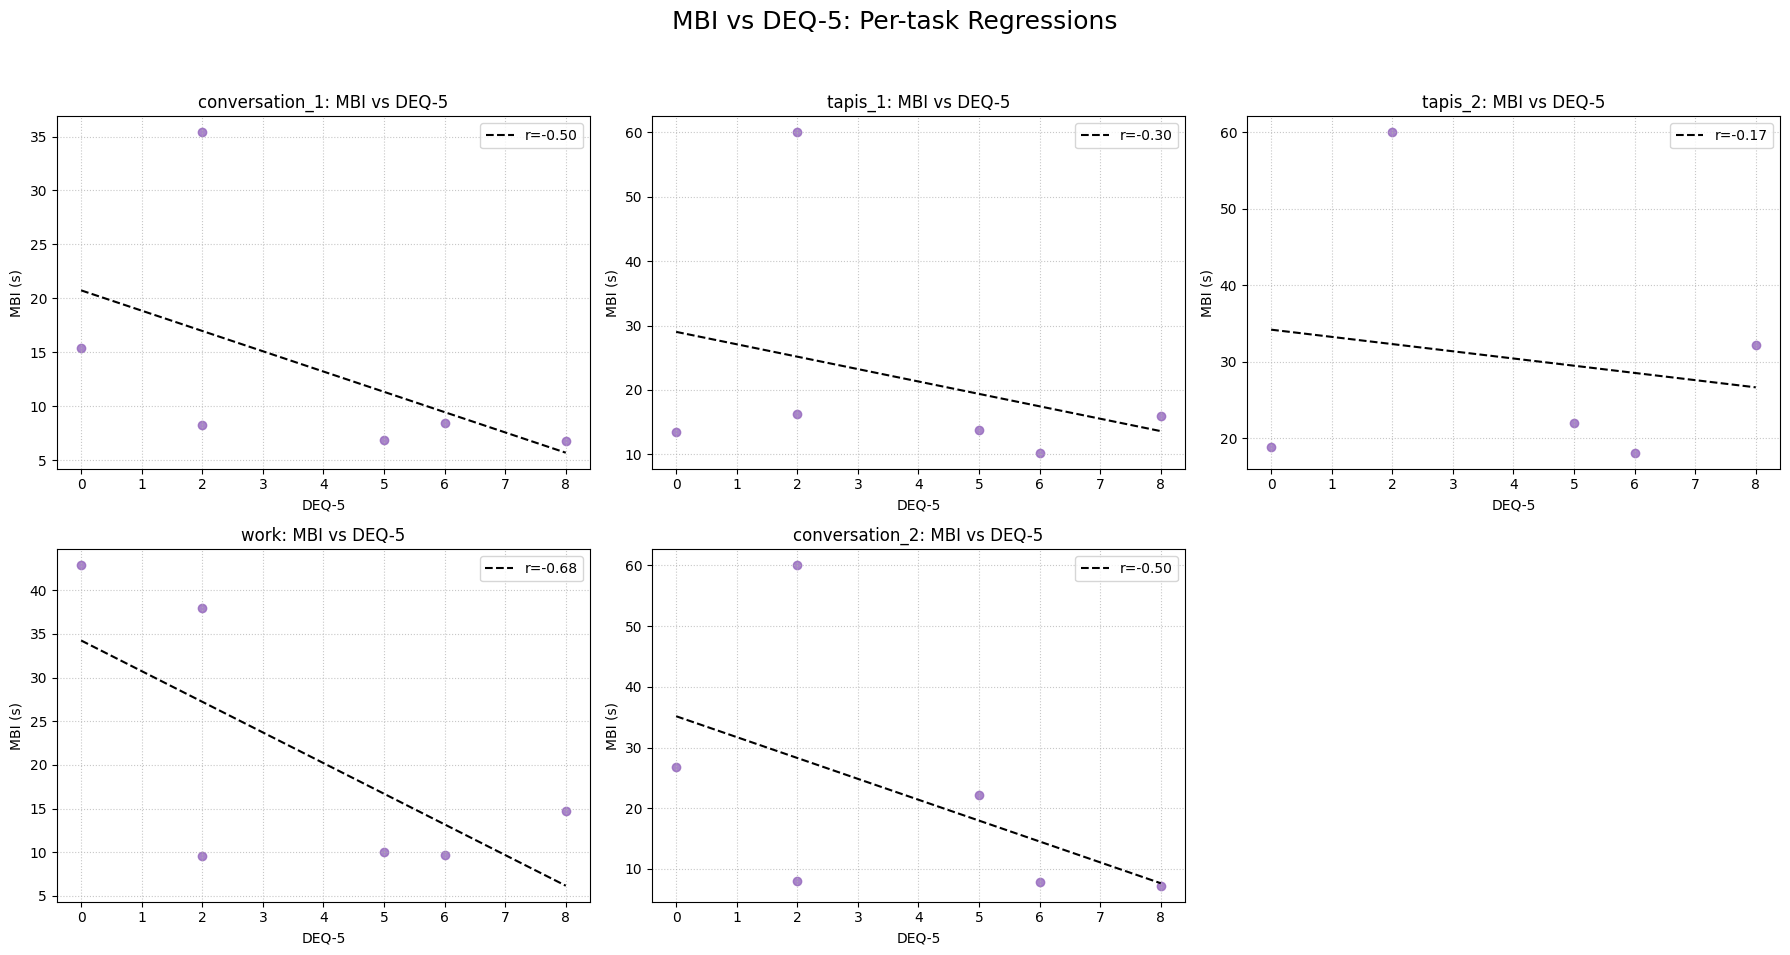

In [27]:
#Regression and plot for each task of MBI vs DEQ-5
if 'DEQ-5' not in info_df.columns and 'DEQ_5' in info_df.columns:
    info_df['DEQ-5'] = info_df['DEQ_5']

task_list = [t for t in df['task_type'].dropna().unique() if isinstance(t, str)]
n_tasks = len(task_list)
n_cols = 3
n_rows = math.ceil(n_tasks / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, task in enumerate(task_list):
    ax = axes[i]
    df_task = df[df['task_type'] == task].copy()
    df_task['MBI_value'] = df_task['MBI Value (Longest Gap, s)'].astype(str).str.replace(',', '.').astype(float)
    df_task.loc[df_task['MBI_value'] < 1, 'MBI_value'] = 60
    df_task_merged = pd.merge(df_task[['Participant', 'MBI_value']], info_df[['Participant', 'DEQ-5']], on='Participant', how='left')
    x = df_task_merged['DEQ-5']
    y = df_task_merged['MBI_value']
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]
    if len(x) > 2:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        ax.scatter(x, y, color='tab:purple', alpha=0.8)
        ax.plot(np.sort(x), slope * np.sort(x) + intercept, color='black', linestyle='--', label=f'r={r_value:.2f}')
        ax.set_title(f'{task}: MBI vs DEQ-5')
        ax.set_xlabel('DEQ-5')
        ax.set_ylabel('MBI (s)')
        ax.legend()
    else:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_title(f'{task}: MBI vs DEQ-5')
        ax.set_xlabel('DEQ-5')
        ax.set_ylabel('MBI (s)')
    ax.grid(True, linestyle='dotted', alpha=0.7)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('MBI vs DEQ-5: Per-task Regressions', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

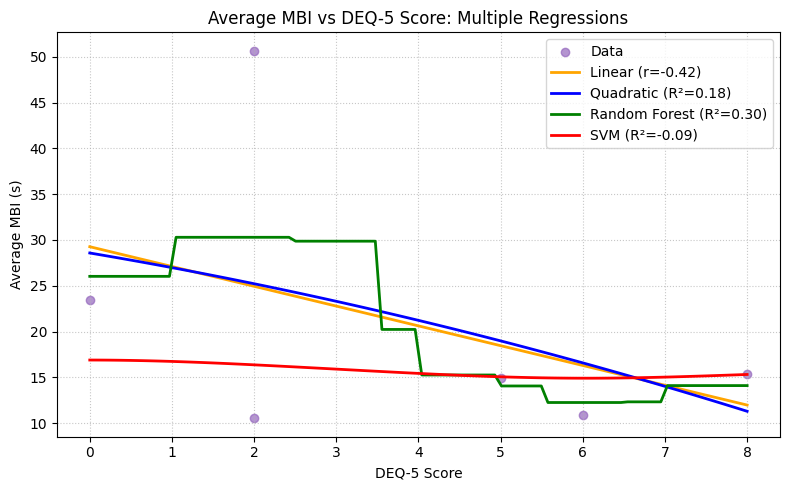

In [28]:
#plot the different regression on DEQ-5 and MBI
df_merged = pd.merge(
    df_merged, 
    info_df[['Participant', 'DEQ-5']], 
    on='Participant', 
    how='left'
)

df_valid = df_merged.dropna(subset=['DEQ-5_x', 'Avg_MBI'])

X = df_valid['DEQ-5_x'].values.reshape(-1, 1)
y = df_valid['Avg_MBI'].values
x_flat = X.flatten()

# Linear regression (scipy)
slope, intercept, r_value, p_value, std_err = linregress(x_flat, y)
X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_lin_plot = slope * X_plot.flatten() + intercept

# Quadratic regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
X_poly_plot = poly.transform(X_plot)
quad_model = LinearRegression().fit(X_poly, y)
y_quad_plot = quad_model.predict(X_poly_plot)
y_quad_pred = quad_model.predict(X_poly)
quad_r2 = r2_score(y, y_quad_pred)

# Random Forest regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_rf_plot = rf_model.predict(X_plot)
y_rf_pred = rf_model.predict(X)
rf_r2 = r2_score(y, y_rf_pred)

# SVM regression
svm_model = SVR(kernel='rbf')
svm_model.fit(X, y)
y_svm_plot = svm_model.predict(X_plot)
y_svm_pred = svm_model.predict(X)
svm_r2 = r2_score(y, y_svm_pred)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x_flat, y, label='Data', color='tab:purple', alpha=0.7)
plt.plot(X_plot, y_lin_plot, label=f'Linear (r={r_value:.2f})', color='orange', linewidth=2)
plt.plot(X_plot, y_quad_plot, label=f'Quadratic (R²={quad_r2:.2f})', color='blue', linewidth=2)
plt.plot(X_plot, y_rf_plot, label=f'Random Forest (R²={rf_r2:.2f})', color='green', linewidth=2)
plt.plot(X_plot, y_svm_plot, label=f'SVM (R²={svm_r2:.2f})', color='red', linewidth=2)

plt.xlabel('DEQ-5 Score')
plt.ylabel('Average MBI (s)')
plt.title('Average MBI vs DEQ-5 Score: Multiple Regressions')
plt.legend()
plt.grid(True, linestyle='dotted', alpha=0.7)
plt.tight_layout()
plt.show()
